We aim to highlight news stories based on their frequency, but with an additional layer of intelligence to help users quickly identify the most significant highlights. For example, a "superstar getting divorced" might be reported everywhere and is clearly breaking news, but without a proper system, it could get buried among other trending but less critical stories.

Consider another case: a "celebrity posting vacation photos on Instagram" may also be widely circulated and appear across various platforms due to the celebrity's popularity. However, despite its high frequency, it isn't breaking news—just viral content.

One key challenge we faced was the lack of a suitable dataset to differentiate between frequent but non-essential news and genuinely significant events.

To overcome this, we designed a method called Synthetic Knowledge Data Distillation. In this approach:

A larger model (the teacher) generates synthetic data, which can include examples, labels, or even entire datasets.
A smaller model (the student) is then trained from scratch or fine-tuned on this generated data to better identify and prioritize meaningful news.

In [25]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dagshub


# Trial 1
Knowledge Distillation train and test data with the same model

In [7]:
df = pd.read_csv('../data/processed/breaking_news_dataset.csv')
df

,summary,label
0,"Breaking: A cyberattack has hit Sydney, causin...",1
1,"Breaking: A explosion has hit Paris, causing m...",1
2,Urgent: president in Chicago faces severe dama...,1
3,university in Chicago launches a new product i...,0
4,university in Paris launches a new product in ...,0
...,...,...
4995,The annual festival in Berlin attracts hundred...,0
4996,Alert: Thousands affected after storm strikes ...,1
4997,Alert: Thousands affected after flood strikes ...,1
4998,Urgent: tech giant in Berlin faces severe dama...,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   summary  5000 non-null   object
 1   label    5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.3+ KB


In [21]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(df[['summary']], df[['label']], test_size=0.3, random_state=42)


The reason behind splitting the data first is to avoid, data leakage.

In [26]:
# Vectorize the training data
vectorizer = CountVectorizer(max_features=10000)  
X_train_vec = vectorizer.fit_transform(X_train['summary']).toarray()
# Vectorize the test data using the same vectorizer
X_test_vec = vectorizer.transform(X_test['summary']).toarray()



In [28]:
dagshub.init(repo_owner='MitVinay', repo_name='news-chatbot', mlflow=True)
mlflow.set_experiment("RF Baseline")

Accessing as MitVinay

Initialized MLflow to track repo "MitVinay/news-chatbot"

Repository MitVinay/news-chatbot initialized!

2025/03/20 14:27:57 INFO mlflow.tracking.fluent: Experiment with name 'RF Baseline' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/b7c443a6425c4db68bf5a2c3006beb25', creation_time=1742441277449, experiment_id='0', last_update_time=1742441277449, lifecycle_stage='active', name='RF Baseline', tags={}>

/Users/vinaymittal/.local/share/virtualenvs/news-chatbot-Q2ywUKKQ/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2025/03/20 14:35:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest_Baseline_TrainTestSplit at: https://dagshub.com/MitVinay/news-chatbot.mlflow/#/experiments/0/runs/d23e40eb7d0b4def9e3eb90bddd9c361
🧪 View experiment at: https://dagshub.com/MitVinay/news-chatbot.mlflow/#/experiments/0
Accuracy: 1.0


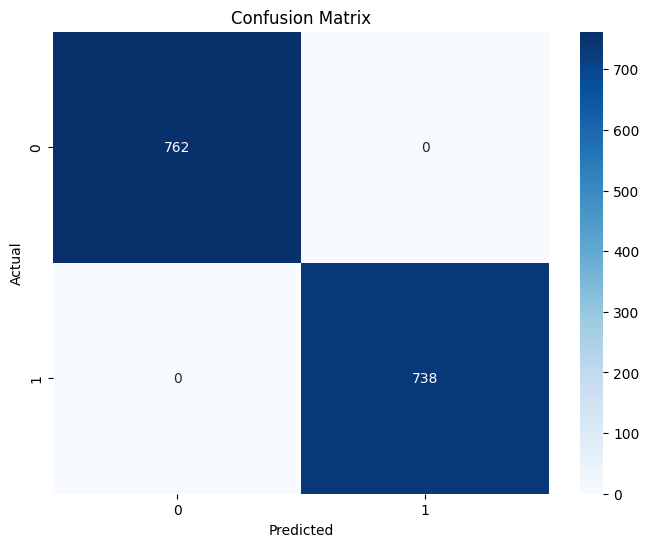

In [ ]:
with mlflow.start_run() as run:
    # Log a description for the run
    mlflow.set_tag("mlflow.runName", "RandomForest_Baseline_TrainTestSplit")
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type", "RandomForestClassifier")

    # Add a description
    mlflow.set_tag("description", "Baseline RandomForest model for breaking news classification using Bag of Words (BoW) with a simple train-test split")

    # Log parameters for the vectorizer
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("vectorizer_max_features", vectorizer.max_features)

    # Log Random Forest parameters
    n_estimators = 200
    max_depth = 15

    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)

    # Initialize and train the model
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train_vec, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test_vec)

    # Log metrics for each class and accuracy
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):  # For precision, recall, f1-score, etc.
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    # Confusion matrix plot
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    # Save and log the confusion matrix plot
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Log the Random Forest model
    mlflow.sklearn.log_model(model, "random_forest_model")

# Display final accuracy
print(f"Accuracy: {accuracy}")

As we can see above, the accuracy of the model is too good—too good to be true. So, there is a high chance of data contamination. Therefore, we are going with the second plan.

# Trial 2: Training and test data from different model

In [40]:
df_train = pd.read_csv('../data/processed/breaking_news_dataset.csv')
df_test = pd.read_csv('../data/processed/breaking_news_dataset_test.csv')

In [41]:
# Vectorize the training data
vectorizer = CountVectorizer(max_features=10000)  
X_train_vec = vectorizer.fit_transform(df_train['summary']).toarray()
y_train = df_train["label"]
# Vectorize the test data using the same vectorizer
X_test_vec = vectorizer.transform(df_test['summary']).toarray()
y_test = df_test["label"]

In [42]:
dagshub.init(repo_owner='MitVinay', repo_name='news-chatbot', mlflow=True)
mlflow.set_experiment("RF Baseline")

Initialized MLflow to track repo "MitVinay/news-chatbot"

Repository MitVinay/news-chatbot initialized!

<Experiment: artifact_location='mlflow-artifacts:/b7c443a6425c4db68bf5a2c3006beb25', creation_time=1742441277449, experiment_id='0', last_update_time=1742441277449, lifecycle_stage='active', name='RF Baseline', tags={}>

2025/03/20 14:59:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Trial 2 at: https://dagshub.com/MitVinay/news-chatbot.mlflow/#/experiments/0/runs/8e29ce962dec423f9cb05a6ad9c594e4
🧪 View experiment at: https://dagshub.com/MitVinay/news-chatbot.mlflow/#/experiments/0
Accuracy: 0.652


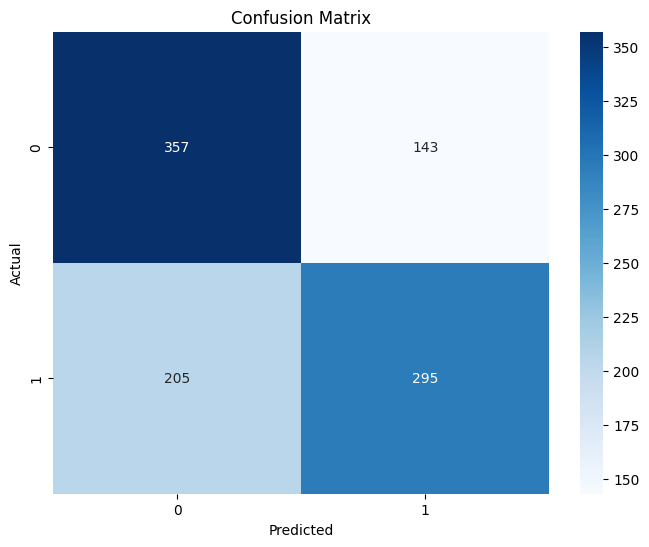

In [43]:
with mlflow.start_run() as run:
    # Log a description for the run
    mlflow.set_tag("mlflow.runName", "Trial 2")
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type", "RandomForestClassifier")

    # Add a description
    mlflow.set_tag("description", "Baseline RandomForest model for breaking news classification using Bag of Words (BoW) with a simple train-test split")

    # Log parameters for the vectorizer
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("vectorizer_max_features", vectorizer.max_features)

    # Log Random Forest parameters
    n_estimators = 200
    max_depth = 15

    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)

    # Initialize and train the model
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train_vec, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test_vec)

    # Log metrics for each class and accuracy
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):  # For precision, recall, f1-score, etc.
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    # Confusion matrix plot
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    # Save and log the confusion matrix plot
    plt.savefig("confusion_matrix_trial2.png")
    mlflow.log_artifact("confusion_matrix_trial2.png")

    # Log the Random Forest model
    mlflow.sklearn.log_model(model, "random_forest_model")

# Display final accuracy
print(f"Accuracy: {accuracy}")